# **Laboraty work № 1**

**Леник Нікіта**

**Бугір Єлизавета**

## **A purpose of experiment**

In this laboratory work, four graph algorithms have been implemented: Prim’s algorithm, Kruskal’s algorithm, Bellman-Ford algorithm, and Floyd-Warshall algorithm. The purpose is to analyze their performance and behavior under varying conditions, particularly when applied to graphs with different numbers of vertices. Through a series of experiments, the impact of increasing the number of vertices on the performance of each algorithm has been examined, providing results to work with.

## **Tools**

In [2]:
# %pip install --upgrade pip
# %pip install networkx
# %pip install matplotlib
# %pip install tqdm
# %pip install pandas
# %pip install numpy
# %pip install graphviz
# %pip install scikit-learn
# %pip install seaborn

In [3]:
import random
import time
from collections import Counter
from itertools import combinations, groupby
from queue import PriorityQueue
from typing import Any, Optional, Tuple

import graphviz
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from networkx.algorithms import (bellman_ford_predecessor_and_distance,
                                 floyd_warshall_predecessor_and_distance, tree)
from networkx.algorithms.shortest_paths.weighted import \
    bellman_ford_predecessor_and_distance
from networkx.exception import NetworkXNoCycle
from sklearn.datasets import load_breast_cancer, make_moons
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from tqdm import tqdm


---

### **Task 1. Algorithm's analysis**

#### Generating graph

In [4]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(
    num_of_nodes: int, completeness: int, directed: bool = False, draw: bool = False
):
    """
    Generates a random graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))

    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)

    for u, v, w in G.edges(data=True):
        w["weight"] = random.randint(-5, 20)

    if draw:
        plt.figure(figsize=(10, 6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(
                G,
                pos,
                node_color="lightblue",
                with_labels=True,
                node_size=500,
                arrowsize=20,
                arrows=True,
            )
            labels = nx.get_edge_attributes(G, "weight")
            nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        else:
            nx.draw(G, node_color="lightblue", with_labels=True, node_size=500)

    return G

---

### **Time measument functions**

In [5]:
def remove_negative_cycles(G: nx.Graph):
    """
    Detects and removes negative cycles from a graph by deleting one edge from each detected cycle.
    Returns:
        G (nx.DiGraph): The modified graph without negative-weight cycles.
    """
    try:
        bellman_ford_predecessor_and_distance(G, 0)
        return G
    except nx.NetworkXUnbounded:
        try:
            cycle = nx.find_cycle(G, orientation="original")
            G.remove_edge(*cycle[0][:2])
            return remove_negative_cycles(G)
        except NetworkXNoCycle:
            return G

def measure_algorithms_on_same_graph(num_nodes, algorithms, iterations=100, completeness=0.4, safe_graph=True, directed=True):
    """
    Measures the execution time of multiple Bellman-Ford implementations on the same graph.
    Returns:
        avg_times (dict): Dictionary mapping algorithm names to their average execution time.
    """
    total_times = {name: 0.0 for name in algorithms}

    for _ in tqdm(range(iterations), desc=f"Measuring for {num_nodes} vertices"):
        G = gnp_random_connected_graph(num_nodes, completeness, directed)

        if safe_graph:
            G = remove_negative_cycles(G)

        for name, func in algorithms.items():
            start_time = time.time()
            func(G.copy())
            end_time = time.time()
            total_times[name] += (end_time - start_time)

    avg_times = {name: total / iterations for name, total in total_times.items()}
    return avg_times

def compare_algorithms(vertex_counts, algorithms, iterations=100, completeness=0.4, safe_graph=True, directed=True):
    """
    Compares the execution time of different Bellman-Ford implementations.

    Returns:
        results (dict): Dictionary containing average times for each algorithm.
    """
    results = {alg_name: [] for alg_name in algorithms}

    for num_nodes in vertex_counts:
        print(f"\n~~~~~~ Testing with {num_nodes} vertices ~~~~~~")
        avg_times = measure_algorithms_on_same_graph(num_nodes, algorithms, iterations, completeness, safe_graph, directed)

        for alg_name, avg_time in avg_times.items():
            results[alg_name].append((num_nodes, avg_time))
            print(f"Algorithm {alg_name} on {num_nodes} vertices: avg time = {avg_time:.6f} seconds")

    return results


---

### **Subtask 1.1**

#### **Kruskal's algorithm**

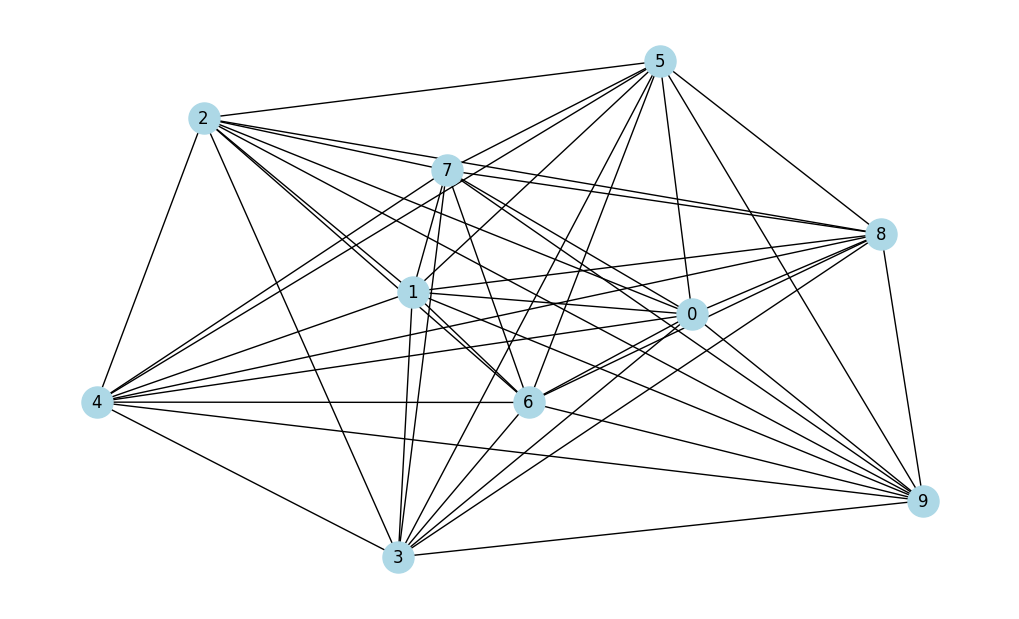

In [6]:
G = gnp_random_connected_graph(10, 1, False, True)

---

### **Kruskal implementation**

In [7]:
def kruskal_from_graph(G):
    """
    Wrapper function to extract the number of nodes and edges from a graph object
    and call the kruskal function.

    :param G: NetworkX graph object
    :return: List of edges in the Minimum Spanning Tree
    """
    n = len(G.nodes)
    edges = [(d['weight'], u, v) for u, v, d in G.edges(data=True)]
    return kruskal(n, edges)

def kruskal(n, edges):
    """
    Kruskal’s algorithm for finding the Minimum Spanning Tree.

    :param n: number of vertices in the graph.
    :param edges: list of edges in the format (weight, u, v).
    :return: list of edges in the Minimum Spanning Tree.
    """
    edges.sort()

    parent = {i: i for i in range(n)}
    rank = {i: 0 for i in range(n)}
    mst = []

    for weight, u, v in edges:
        if find(parent, u) != find(parent, v):
            union(parent, rank, u, v)
            mst.append((u, v, weight))
            if len(mst) == n - 1:
                break

    return mst

def find(parent, i):
    if parent[i] != i:
        parent[i] = find(parent, parent[i])
    return parent[i]

def union(parent, rank, x, y):
    root_x = find(parent, x)
    root_y = find(parent, y)

    if root_x != root_y:
        if rank[root_x] < rank[root_y]:
            parent[root_x] = root_y
        elif rank[root_x] > rank[root_y]:
            parent[root_y] = root_x
        else:
            parent[root_y] = root_x
            rank[root_x] += 1



### **Algorithm Explanation**
1. **Kruskal’s algorithm is a greedy algorithm used to find the Minimum Spanning Tree (MST)**. Unlike Prim's algorithm, which grows the MST one node at a time, Kruskal’s algorithm starts with an empty tree and **adds edges in increasing order of weight** while ensuring no cycles are formed.

2. **Sorting the edges**:  
   - The algorithm starts by sorting all edges in **non-decreasing** order based on their weights.
   - This allows us to process the edges in order of increasing cost.

3. **Union-Find Data Structure**:  
   - To efficiently manage which vertices are connected, Kruskal’s algorithm uses the **Disjoint Set Union (DSU)**, also known as the **Union-Find** data structure.
   - The DSU supports **finding the root** of a set (`find` function) and **merging two sets** (`union` function) efficiently.

4. **Adding edges to the MST**:  
   - The algorithm iterates through the sorted edges and, for each edge `(u, v, weight)`, checks if `u` and `v` belong to different sets (i.e., are not yet connected).
   - If they are in different sets, the edge is added to the MST, and `union(u, v)` merges the sets.

5. **Cycle Prevention**:  
   - If `u` and `v` are already in the same set, adding the edge would create a cycle, so it is skipped.
   - The process continues until we have exactly **V-1 edges** in the MST, where `V` is the number of vertices.

6. **The algorithm terminates when we have included `V-1` edges**, ensuring a Minimum Spanning Tree.



### **Time Complexity**
The time complexity of Kruskal’s algorithm is $O(|E| log \|E|) + O(|E| α(V))$,where:

- $O(|E| log \|E|)$ comes from sorting the edges (E = number of edges).
- $O(|E| α(V))$ comes from the Union-Find operations (where α(V) is the inverse Ackermann function, which is nearly constant).

Because sorting makes the complexity better, Kruskal’s algorithm runs in $O(|E| α(V))$.


---

### **Comparing Own Implemented and NetworkX's Algorithms**

The graph represents the time differences betweeen NetworkX algorithm and custom Prim's algorithm. 

The **y-axis** - average time in miliseconds

THe **x-axis** - number if vertices in graph


~~~~~~ Testing with 10 vertices ~~~~~~


Measuring for 10 vertices: 100%|██████████| 100/100 [00:00<00:00, 1461.07it/s]


Algorithm custom kruskal on 10 vertices: avg time = 0.000061 seconds
Algorithm networkx kruskal on 10 vertices: avg time = 0.000571 seconds

~~~~~~ Testing with 20 vertices ~~~~~~


Measuring for 20 vertices: 100%|██████████| 100/100 [00:00<00:00, 1645.17it/s]


Algorithm custom kruskal on 20 vertices: avg time = 0.000184 seconds
Algorithm networkx kruskal on 20 vertices: avg time = 0.000267 seconds

~~~~~~ Testing with 50 vertices ~~~~~~


Measuring for 50 vertices: 100%|██████████| 100/100 [00:00<00:00, 320.84it/s]


Algorithm custom kruskal on 50 vertices: avg time = 0.000968 seconds
Algorithm networkx kruskal on 50 vertices: avg time = 0.001304 seconds

~~~~~~ Testing with 100 vertices ~~~~~~


Measuring for 100 vertices: 100%|██████████| 100/100 [00:01<00:00, 85.64it/s]


Algorithm custom kruskal on 100 vertices: avg time = 0.003678 seconds
Algorithm networkx kruskal on 100 vertices: avg time = 0.004850 seconds

~~~~~~ Testing with 200 vertices ~~~~~~


Measuring for 200 vertices: 100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


Algorithm custom kruskal on 200 vertices: avg time = 0.014156 seconds
Algorithm networkx kruskal on 200 vertices: avg time = 0.024331 seconds

~~~~~~ Testing with 500 vertices ~~~~~~


Measuring for 500 vertices: 100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


Algorithm custom kruskal on 500 vertices: avg time = 0.096045 seconds
Algorithm networkx kruskal on 500 vertices: avg time = 0.200136 seconds

~~~~~~ Testing with 1000 vertices ~~~~~~


Measuring for 1000 vertices: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]

Algorithm custom kruskal on 1000 vertices: avg time = 0.392513 seconds
Algorithm networkx kruskal on 1000 vertices: avg time = 0.944542 seconds


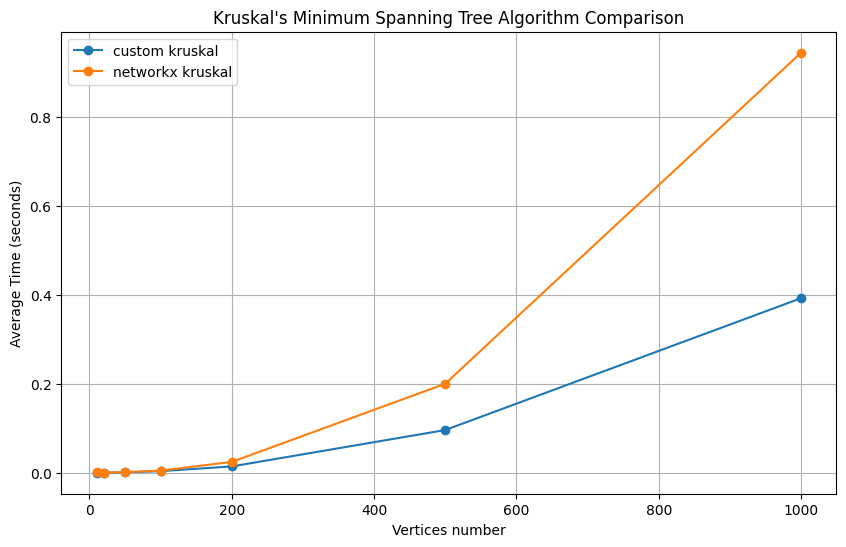

In [8]:

algorithms = {
    "custom kruskal": kruskal_from_graph,
    "networkx kruskal": lambda G: nx.minimum_spanning_tree(G, algorithm="kruskal"),
}

vertex_counts = [10, 20, 50, 100, 200, 500, 1000]
iterations = 100

results = compare_algorithms(
    vertex_counts,
    algorithms,
    iterations=iterations,
    completeness=0.4,
    safe_graph=False,
    directed=False,
)

plt.figure(figsize=(10, 6))
for alg_name, data in results.items():
    nodes, times = zip(*data)
    plt.plot(nodes, times, marker="o", label=alg_name)

plt.xlabel("Vertices number")
plt.ylabel("Average Time (seconds)")
plt.title("Kruskal's Minimum Spanning Tree Algorithm Comparison")
plt.legend()
plt.grid(True)
plt.show()


### **Conclusion**
The custom Kruskal’s algorithm is faster because it avoids extra function call overhead and optimizes Union-Find operations.

---

### **Prim's algorithm**

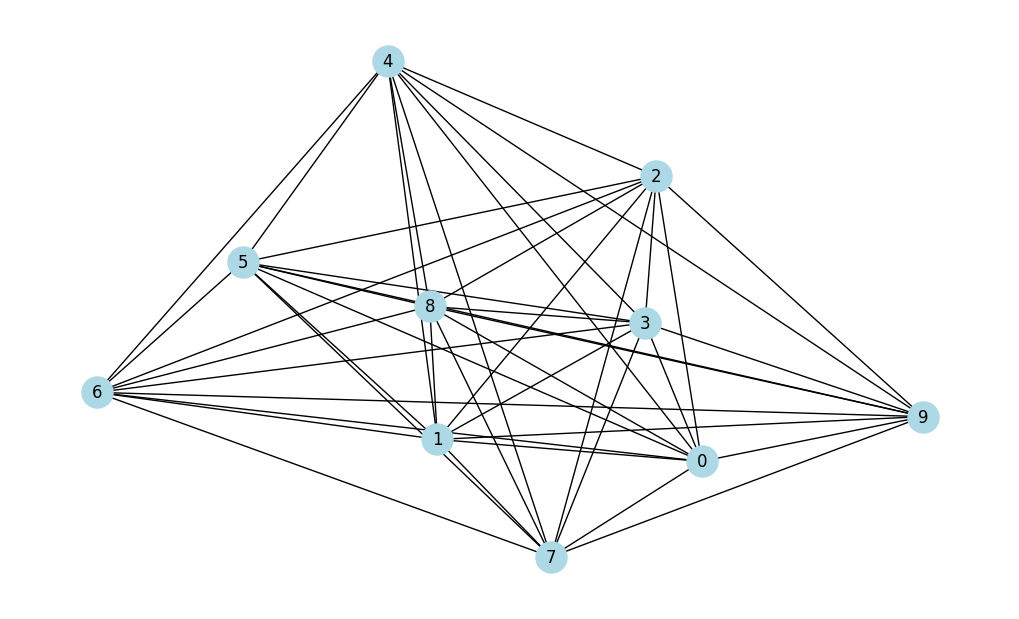

In [9]:
G = gnp_random_connected_graph(10, 1, False, True)

### **Prim's algorithm implementation**

In [10]:
def prims_algorithm(G: nx.Graph) -> nx.Graph:
    """
    Prim's algorithm

    Parameters:
        G (nx.Graph): the undirected weighted graph possbile with negative weights (nx.Graph)

    Returns:
        mst (nx.Graph): Minimum spanning tree (MST)
    """

    mst = nx.Graph()
    start = list(G.nodes)[0]
    visited = {start}
    queue = PriorityQueue()

    # Checks for start node neighbors
    for neighbor, data in G[start].items():
        queue.put((data.get("weight", 1), start, neighbor))

    while not queue.empty() and len(visited) < G.number_of_nodes():
        weight, u, v = queue.get()

        if v in visited:
            continue

        mst.add_edge(u, v, weight=weight)
        visited.add(v)

        # Checks for adjacency nodes
        for neighbor, data in G[v].items():
            if neighbor not in visited:
                queue.put((data.get("weight", 1), v, neighbor))

    return mst

In [11]:
def mst_weight(mst: nx.Graph) -> int:
    """
    Returns the weight of the graph
    """
    return mst.size(weight="weight")

### **Code explenation**
1. As Prim's algorithms operates much like Dijkstra's algorithm we may use binary binary heap as the main data structure.. The main differences that Dijkstra's algorithm cannot work with negative weights.

2. During execution of the algorithm all vertices that are not in the tree reside in a min-priority queue where the key parameter is weight, initial and terminal node(represents the edged)

3. The algorithm starts with the root node, adding it to the MST and markes it as visited. The it add all nodes connected to visited into priority queue

4. In each iteration, the algorithms pulls the edge with the minimum weight from the priority queue. If the distination("v" in the code) node of this edge has not been visited, it adds the edge to the MST 

5. The procces stops when all nodes have been added to the MST, that ensures that we get a spanning tree with the minimal total weight(to calculate the weight we use function "mst_weight" to compare the networkx weight with our)

### **Time complexity (Theoretical)**

The running time of Prim's algorithm really depends on how we implement the priority queue. The fastest way uses a Fibonacci heap, which has constant time for **decrease-key** and **insert** operations with $O(1)$, but it requires self-implementation. 

With a binary heap, the body of the while loop executes $|V|$ times, where $V$ is the set of vertices. Since each **extract-min** operation takes $O(\log V)$ time, the total time for all **extract-min** calls is $O(V \log V)$.

The for loop where each node v is added to the MST and iterates through all its neighbors. As the sum of all degrees in the graph is $2|E|$ the total number of iterations is $O(|E|)$

In each iteration, we insert an edge into a queue which takes the $O(\lg V)$ and for all iterations, it is $O(E \lg V)$

So the **total cost** of Prim's alogrithm is $$O(V \lg V) + O(E \lg V) = O(E \lg V)$$

---

### **Custom Prim's algorithm**

In [12]:
mst = prims_algorithm(G)
(mst.edges, len(mst.edges), mst_weight(mst))

(EdgeView([(0, 7), (0, 4), (0, 5), (4, 1), (5, 9), (9, 6), (6, 2), (2, 3), (2, 8)]),
 9,
 -6.0)

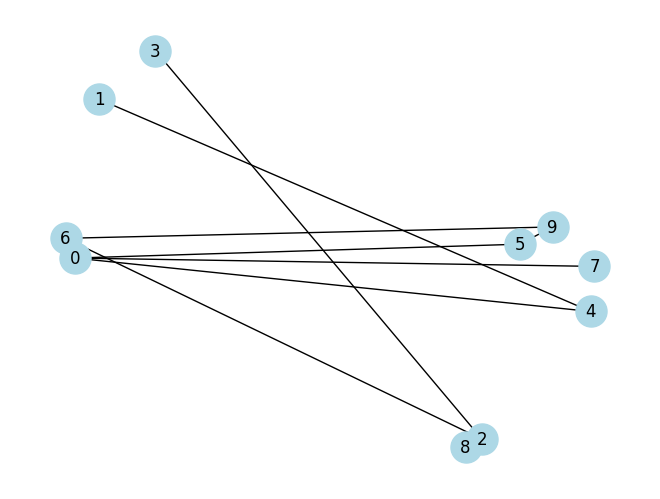

In [13]:
nx.draw(mst, node_color="lightblue", with_labels=True, node_size=500)

---

### **Comparing custom Prim's algorithm with networkx algorithm**

The graph represents the time differences betweeen NetworkX algorithm and custom Prim's algorithm. 

The **y-axis** - average time in miliseconds

THe **x-axis** - number if vertices in graph

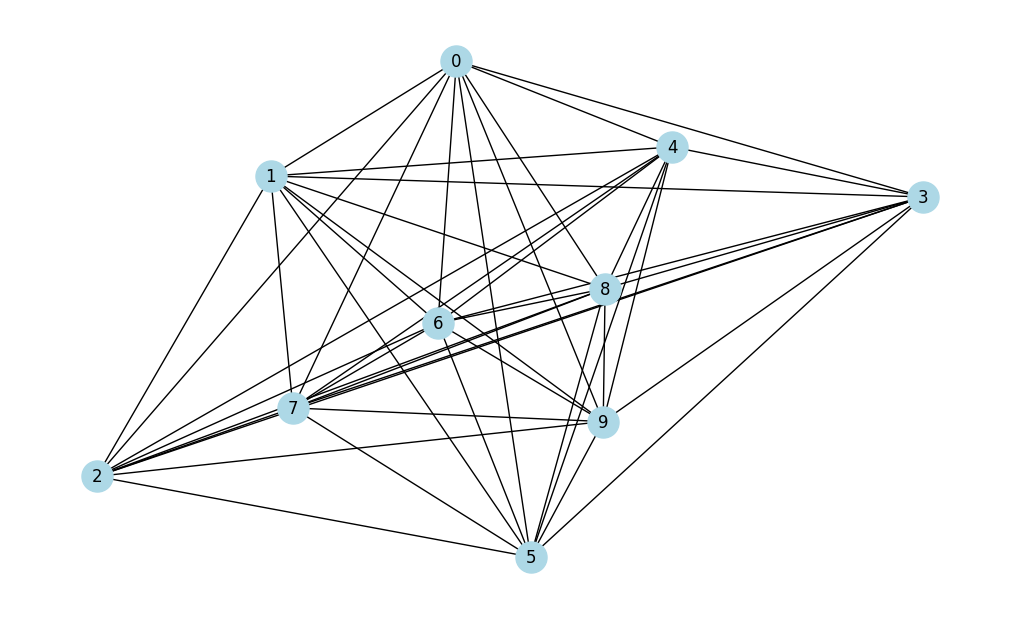

In [14]:
G = gnp_random_connected_graph(10, 1, False, True)

All measurments are done on fully connected graph with multiple edges


~~~~~~ Testing with 10 vertices ~~~~~~


Measuring for 10 vertices: 100%|██████████| 100/100 [00:00<00:00, 4497.19it/s]


Algorithm custom prim on 10 vertices: avg time = 0.000098 seconds
Algorithm networkx prim on 10 vertices: avg time = 0.000077 seconds

~~~~~~ Testing with 20 vertices ~~~~~~


Measuring for 20 vertices: 100%|██████████| 100/100 [00:00<00:00, 1534.16it/s]


Algorithm custom prim on 20 vertices: avg time = 0.000291 seconds
Algorithm networkx prim on 20 vertices: avg time = 0.000211 seconds

~~~~~~ Testing with 50 vertices ~~~~~~


Measuring for 50 vertices: 100%|██████████| 100/100 [00:00<00:00, 303.61it/s]


Algorithm custom prim on 50 vertices: avg time = 0.001464 seconds
Algorithm networkx prim on 50 vertices: avg time = 0.001062 seconds

~~~~~~ Testing with 100 vertices ~~~~~~


Measuring for 100 vertices: 100%|██████████| 100/100 [00:01<00:00, 82.98it/s]


Algorithm custom prim on 100 vertices: avg time = 0.005169 seconds
Algorithm networkx prim on 100 vertices: avg time = 0.003868 seconds

~~~~~~ Testing with 200 vertices ~~~~~~


Measuring for 200 vertices: 100%|██████████| 100/100 [00:05<00:00, 17.59it/s]


Algorithm custom prim on 200 vertices: avg time = 0.021366 seconds
Algorithm networkx prim on 200 vertices: avg time = 0.022094 seconds

~~~~~~ Testing with 500 vertices ~~~~~~


Measuring for 500 vertices: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Algorithm custom prim on 500 vertices: avg time = 0.145810 seconds
Algorithm networkx prim on 500 vertices: avg time = 0.185119 seconds

~~~~~~ Testing with 1000 vertices ~~~~~~


Measuring for 1000 vertices: 100%|██████████| 100/100 [02:56<00:00,  1.76s/it]

Algorithm custom prim on 1000 vertices: avg time = 0.581706 seconds
Algorithm networkx prim on 1000 vertices: avg time = 0.870498 seconds


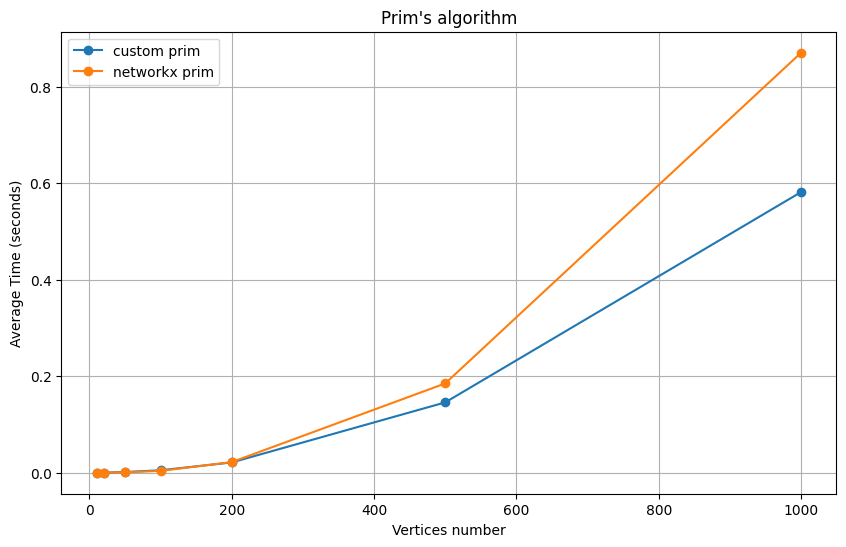

In [15]:
algorithms = {
    "custom prim": prims_algorithm,
    "networkx prim": lambda G: nx.minimum_spanning_tree(G, algorithm="prim"),
}

vertex_counts = [10, 20, 50, 100, 200, 500, 1000]
iterations = 100
results = compare_algorithms(
    vertex_counts,
    algorithms,
    iterations=iterations,
    completeness=0.4,
    safe_graph=False,
    directed=False,
)

plt.figure(figsize=(10, 6))
for alg_name, data in results.items():
    nodes, times = zip(*data)
    plt.plot(nodes, times, marker="o", label=alg_name)
plt.xlabel("Vertices number")
plt.ylabel("Average Time (seconds)")
plt.title("Prim's algorithm")
plt.legend()
plt.grid(True)
plt.show()

As we see on the graph the custom Prim's algorithm takes less time than networkx's algorithm. This happens because networkx uses many more checking factors during algorithm execution

---

### **Comparison of custom Prim's and custom Kruskal's algorithms**

The graph represents the time differences betweeen NetworkX algorithm and custom Prim's algorithm. 

The **y-axis** - average time in miliseconds

THe **x-axis** - number if vertices in graph


~~~~~~ Testing with 10 vertices ~~~~~~


Measuring for 10 vertices: 100%|██████████| 100/100 [00:00<00:00, 4256.97it/s]


Algorithm custom kruskal on 10 vertices: avg time = 0.000089 seconds
Algorithm custom prim on 10 vertices: avg time = 0.000057 seconds

~~~~~~ Testing with 20 vertices ~~~~~~


Measuring for 20 vertices: 100%|██████████| 100/100 [00:00<00:00, 2079.26it/s]


Algorithm custom kruskal on 20 vertices: avg time = 0.000184 seconds
Algorithm custom prim on 20 vertices: avg time = 0.000143 seconds

~~~~~~ Testing with 50 vertices ~~~~~~


Measuring for 50 vertices: 100%|██████████| 100/100 [00:00<00:00, 423.29it/s]


Algorithm custom kruskal on 50 vertices: avg time = 0.000872 seconds
Algorithm custom prim on 50 vertices: avg time = 0.000732 seconds

~~~~~~ Testing with 100 vertices ~~~~~~


Measuring for 100 vertices: 100%|██████████| 100/100 [00:00<00:00, 117.12it/s]


Algorithm custom kruskal on 100 vertices: avg time = 0.003218 seconds
Algorithm custom prim on 100 vertices: avg time = 0.002466 seconds

~~~~~~ Testing with 200 vertices ~~~~~~


Measuring for 200 vertices: 100%|██████████| 100/100 [00:03<00:00, 25.91it/s]


Algorithm custom kruskal on 200 vertices: avg time = 0.016685 seconds
Algorithm custom prim on 200 vertices: avg time = 0.010284 seconds

~~~~~~ Testing with 500 vertices ~~~~~~


Measuring for 500 vertices: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Algorithm custom kruskal on 500 vertices: avg time = 0.091469 seconds
Algorithm custom prim on 500 vertices: avg time = 0.077159 seconds

~~~~~~ Testing with 1000 vertices ~~~~~~


Measuring for 1000 vertices: 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]

Algorithm custom kruskal on 1000 vertices: avg time = 0.381125 seconds
Algorithm custom prim on 1000 vertices: avg time = 0.324590 seconds


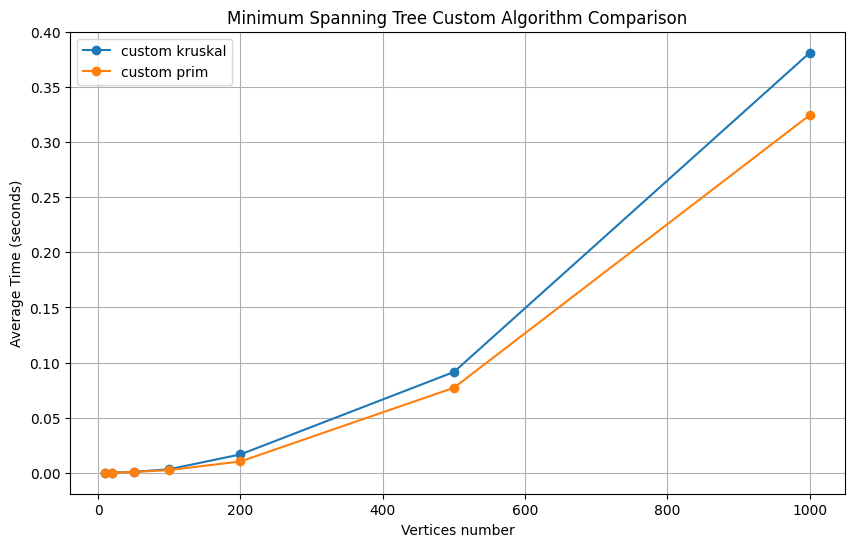

In [16]:
algorithms = {
    "custom kruskal": kruskal_from_graph,
    "custom prim": lambda G: prims_algorithm,
}

vertex_counts = [10, 20, 50, 100, 200, 500, 1000]
iterations = 100

results = compare_algorithms(
    vertex_counts,
    algorithms,
    iterations=iterations,
    completeness=0.4,
    safe_graph=False,
    directed=False,
)

plt.figure(figsize=(10, 6))
for alg_name, data in results.items():
    nodes, times = zip(*data)
    plt.plot(nodes, times, marker="o", label=alg_name)

plt.xlabel("Vertices number")
plt.ylabel("Average Time (seconds)")
plt.title( "Minimum Spanning Tree Custom Algorithm Comparison")
plt.legend()
plt.grid(True)
plt.show()


As we see the Kruskal's algorithm is sligthly faster

---

### **Subtask 1.2**

#### **Generating the directed graph with possible negative weights**

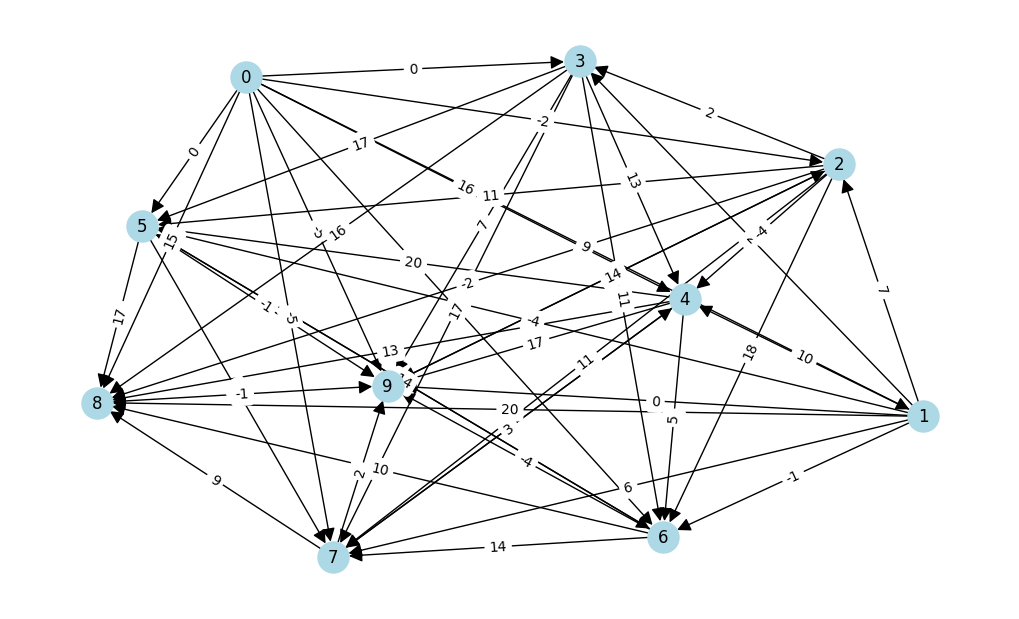

In [17]:
G = gnp_random_connected_graph(10, 1, True, True)

### **Bellman-Ford algorithm implementation**

In [18]:
def bf_algorithm(G: nx.Graph, source: int) -> tuple[dict, dict]:
    """
    Bellman-Ford algorithm

    Parameters:
        G (nx.Graph): directed weighted graph the negative weights are possible (nx.Graph).

    If negative cycle detected raises an Error.

    Returns:
        predecessors, distances_dict tuple[dict, dict]: First dictionary defines the predecessors, Second the dictionary with minimal weights
    """
    distance = np.full(G.number_of_nodes(), np.inf)
    distance[source] = 0

    distances_dict = {node: np.inf for node in G.nodes()}
    predecessors = {node: None for node in G.nodes()}
    distances_dict[source] = 0

    # Relax all edges
    for _ in range(G.number_of_nodes() - 1):
        for u, v, data in G.edges(data=True):
            weight = data.get("weight", 0)
            if distance[v] > distance[u] + weight:
                distance[v] = distance[u] + weight
                if v not in predecessors:
                    predecessors[v] = []
                predecessors[v] = [u]
                distances_dict[v] = int(distance[v])

    # Check for negative-weight cycles
    for u, v, data in G.edges(data=True):
        weight = data.get("weight", 0)
        if distance[u] + weight < distance[v]:
            raise ValueError("Negative cycle detected")

    return predecessors, distances_dict

### **Code explanation**

The main purpose of the Bellman-Ford algorithms is to find the shortest path from a single source in which edge weights may be negative. 

1. Create the distance matrix to represent the **relaxation**. If $V.distance > U.distance + Weight(u, v) \quad then \quad V.distance = U.distance + Weight(u, v)$

2. The algorithm relaxes edges, progressively decreasing an estimate of target node "v" on the weight of the shortest path from the source to each node. 

3. After performing the relaxation steps, the algorithm runs one final pass over all the edges. If edge can still be **relaxed**, then the graph contains the negative-weight cycle


### **Time complexity (Theoretical)**

The algorithm makes $|V| - 1$ passes over the edges of the graph. Each step of the for loop consists of relaxing each edge of the graph once. 

The Bellman-Ford algorithm runs in time $O(|V|*|E|)$, as passes over edges take $O(|E|)$ time and the algorithm initializes the distance array in $O(|V|)$ time. If the graph is dense - the number of edges is near the upper bound of edges the time complexity is $O(|V|^2)$


---

### **Comapraing custom Bellman-Ford algorithm with NetworkX's algorithm**

Generating the fully connected directed graph with multiple edges

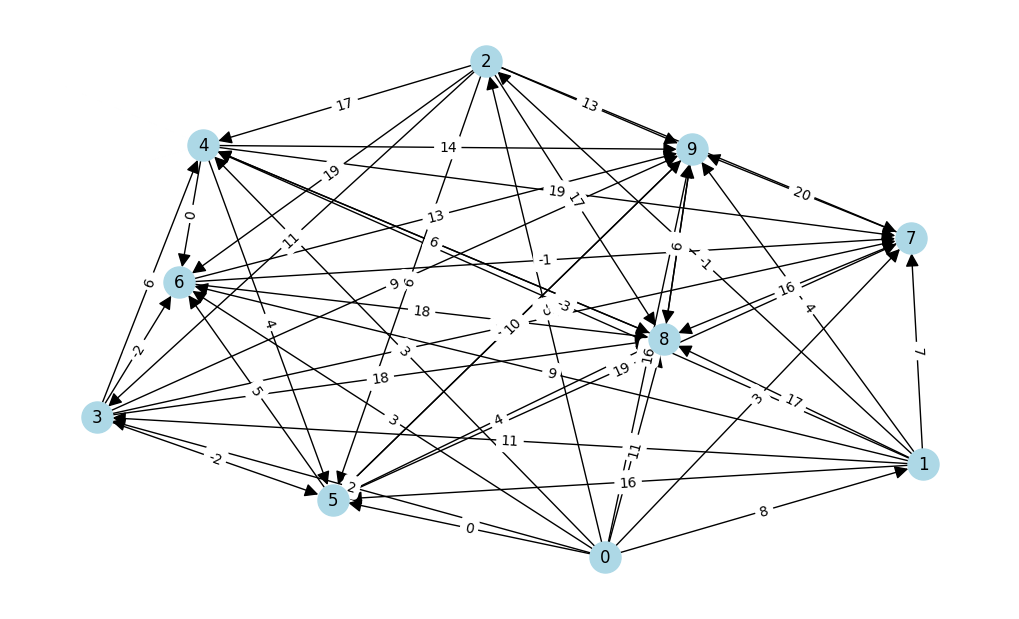

In [19]:
G = gnp_random_connected_graph(10, 1, True, True)

In [20]:
try:
    pred_custom, dist_custom = bf_algorithm(G, 0)
    print("Custom Bellman-Ford")
    print(f"Predecessors: {pred_custom}")
    print(f"Distances: {dist_custom}")
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    print("NetworkX Bellman-Ford")
    print(f"Predecessors: {pred_custom}")
    print(f"Distances: {dist_custom}")

    for k, v in dist_custom.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Custom Bellman-Ford
Predecessors: {0: None, 1: [0], 2: [0], 3: [0], 4: [0], 5: [0], 6: [3], 7: [2], 8: [5], 9: [8]}
Distances: {0: 0, 1: 8, 2: -5, 3: 2, 4: 3, 5: 0, 6: 0, 7: -3, 8: 4, 9: 1}
NetworkX Bellman-Ford
Predecessors: {0: None, 1: [0], 2: [0], 3: [0], 4: [0], 5: [0], 6: [3], 7: [2], 8: [5], 9: [8]}
Distances: {0: 0, 1: 8, 2: -5, 3: 2, 4: 3, 5: 0, 6: 0, 7: -3, 8: 4, 9: 1}
Distance to 0: 0
Distance to 1: 8
Distance to 2: -5
Distance to 3: 2
Distance to 4: 3
Distance to 5: 0
Distance to 6: 0
Distance to 7: -3
Distance to 8: 4
Distance to 9: 1


The algorithm returns the dictionary with predecessors and distances

---

### **Comparing with NetworkX algorithm**

The graph represents the time differences betweeen NetworkX algorithm and custom Prim's algorithm. 

The **y-axis** - average time in miliseconds

THe **x-axis** - number if vertices in graph


~~~~~~ Testing with 10 vertices ~~~~~~


Measuring for 10 vertices: 100%|██████████| 50/50 [00:00<00:00, 2444.86it/s]


Algorithm custom bellman-ford on 10 vertices: avg time = 0.000150 seconds
Algorithm networkx bellman ford on 10 vertices: avg time = 0.000046 seconds

~~~~~~ Testing with 20 vertices ~~~~~~


Measuring for 20 vertices: 100%|██████████| 50/50 [00:00<00:00, 280.35it/s]


Algorithm custom bellman-ford on 20 vertices: avg time = 0.000735 seconds
Algorithm networkx bellman ford on 20 vertices: avg time = 0.000142 seconds

~~~~~~ Testing with 25 vertices ~~~~~~


Measuring for 25 vertices: 100%|██████████| 50/50 [00:00<00:00, 88.13it/s] 


Algorithm custom bellman-ford on 25 vertices: avg time = 0.001262 seconds
Algorithm networkx bellman ford on 25 vertices: avg time = 0.000181 seconds

~~~~~~ Testing with 30 vertices ~~~~~~


Measuring for 30 vertices: 100%|██████████| 50/50 [00:01<00:00, 32.27it/s]


Algorithm custom bellman-ford on 30 vertices: avg time = 0.002048 seconds
Algorithm networkx bellman ford on 30 vertices: avg time = 0.000222 seconds

~~~~~~ Testing with 45 vertices ~~~~~~


Measuring for 45 vertices: 100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


Algorithm custom bellman-ford on 45 vertices: avg time = 0.006116 seconds
Algorithm networkx bellman ford on 45 vertices: avg time = 0.001402 seconds

~~~~~~ Testing with 50 vertices ~~~~~~


Measuring for 50 vertices: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]

Algorithm custom bellman-ford on 50 vertices: avg time = 0.008224 seconds
Algorithm networkx bellman ford on 50 vertices: avg time = 0.001552 seconds


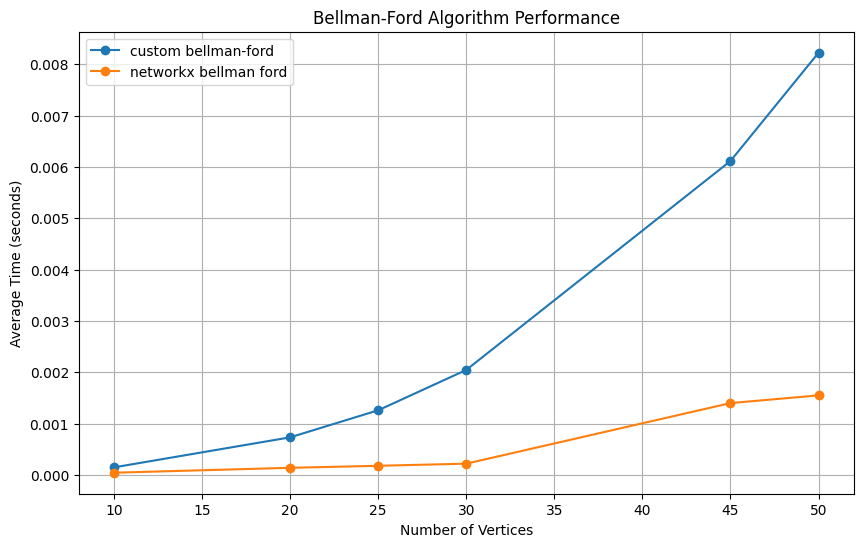

In [21]:
algorithms = {
    "custom bellman-ford": lambda G: bf_algorithm(G, 0),
    "networkx bellman ford": lambda G: bellman_ford_predecessor_and_distance(G, 0),
}

vertex_counts = [10, 20, 25, 30, 45, 50]
iterations = 50

results = compare_algorithms(vertex_counts, algorithms, iterations=iterations, completeness=0.5, safe_graph=True)

# Plotting
plt.figure(figsize=(10, 6))
for alg_name, data in results.items():
    nodes, times = zip(*data)
    plt.plot(nodes, times, marker='o', label=alg_name)

plt.xlabel("Number of Vertices")
plt.ylabel("Average Time (seconds)")
plt.title("Bellman-Ford Algorithm Performance")
plt.legend()
plt.grid(True)
plt.show()


As we see the NetworkX's algorithm runs much faster. The custom Bellman-Ford algorithm is degrades to $O(|V|^2)$ time complexity due to the density of graph

---

### **Floyd-Warshall algorithm**

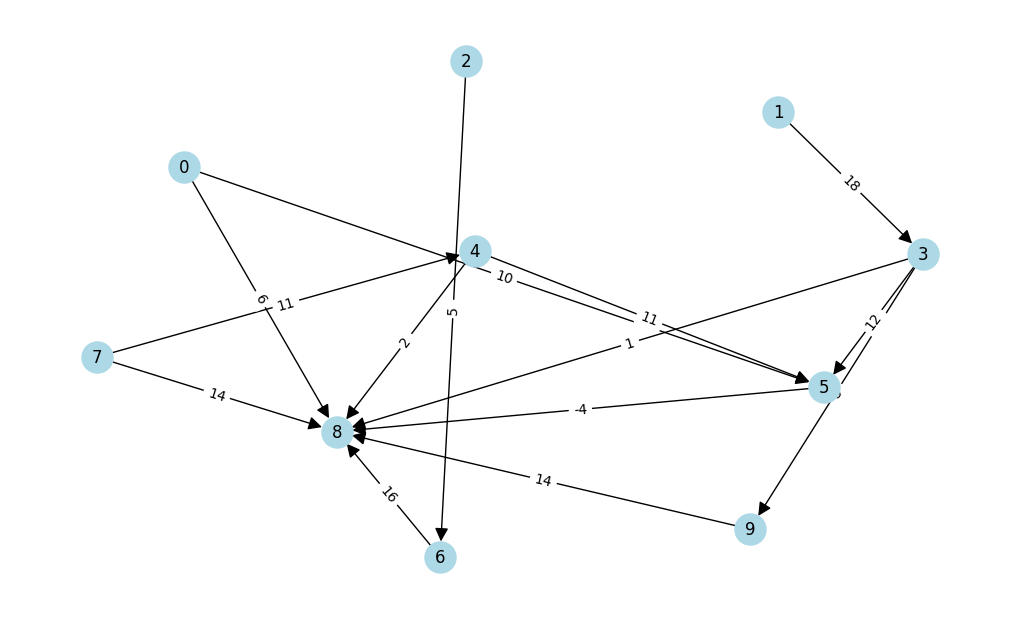

In [22]:
G = gnp_random_connected_graph(10, 0.1, True, True)

### **Custom implementation of Floyd-Warshall's algoritm**

In [23]:

def floyd_warshall(graph: nx.Graph):
    """
    Floyd-Warshall algorithm with negative cycle detection.

    :param graph: a NetworkX graph where edges have a 'weight' attribute.
    :return: a dictionary dist where the shortest distance from each node to every other node is stored.
    """
    nodes = list(graph.nodes())
    inf = float('inf')

    dist = {node: {other: inf for other in nodes} for node in nodes}
    for node in nodes:
        dist[node][node] = 0
    for u, v, data in graph.edges(data=True):
        dist[u][v] = data['weight']

    for k in nodes:
        for i in nodes:
            for j in nodes:
                if dist[i][k] < inf and dist[k][j] < inf:
                    new_distance = dist[i][k] + dist[k][j]
                    if new_distance < dist[i][j]:
                        dist[i][j] = new_distance

    for node in nodes:
        if dist[node][node] < 0:
            pass

    return dist


In [24]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    dist = floyd_warshall(G)
    for k, v in dist.items():
        print(f"Distances with {k} source: {v}")
except:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 1: inf, 2: inf, 3: inf, 4: inf, 5: 10, 6: inf, 7: inf, 8: 6, 9: inf}
Distances with 1 source: {0: inf, 1: 0, 2: inf, 3: 18, 4: inf, 5: 30, 6: inf, 7: inf, 8: 19, 9: 26}
Distances with 2 source: {0: inf, 1: inf, 2: 0, 3: inf, 4: inf, 5: inf, 6: 5, 7: inf, 8: 21, 9: inf}
Distances with 3 source: {0: inf, 1: inf, 2: inf, 3: 0, 4: inf, 5: 12, 6: inf, 7: inf, 8: 1, 9: 8}
Distances with 4 source: {0: inf, 1: inf, 2: inf, 3: inf, 4: 0, 5: 11, 6: inf, 7: inf, 8: 2, 9: inf}
Distances with 5 source: {0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: 0, 6: inf, 7: inf, 8: -4, 9: inf}
Distances with 6 source: {0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: 0, 7: inf, 8: 16, 9: inf}
Distances with 7 source: {0: inf, 1: inf, 2: inf, 3: inf, 4: 11, 5: 22, 6: inf, 7: 0, 8: 13, 9: inf}
Distances with 8 source: {0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 8: 0, 9: inf}
Distances with 9 source: {0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: in

### **Algorithm Explanation: Floyd-Warshall Algorithm**

1. **Floyd-Warshall Algorithm**:  
   The Floyd-Warshall algorithm is a dynamic programming approach to solving the **all-pairs shortest path problem**. It computes the shortest paths between every pair of nodes in a weighted graph, and it can handle both positive and negative edge weights, as long as there are no negative weight cycles.

2. **Initialization**:  
   - The algorithm starts by initializing a **distance matrix** (`dist`) where each entry `dist[i][j]` represents the shortest known distance from node `i` to node `j`. Initially, the distance between any two nodes is set to infinity (`inf`), except for the distance from a node to itself, which is set to 0.
   - For each edge `(u, v)` in the graph, the distance `dist[u][v]` is updated to the weight of the edge.

3. **Dynamic Programming**:  
   - The core of the algorithm involves iterating over all possible intermediate nodes `k`, and for each pair of nodes `(i, j)`, checking whether the path from `i` to `j` can be improved by going through `k`.
   - This is done by checking if `dist[i][j] > dist[i][k] + dist[k][j]`, and if true, the distance `dist[i][j]` is updated.

4. **Negative Cycle Detection**:  
   - After all iterations, the algorithm checks whether there are any negative weight cycles in the graph. A negative cycle would be indicated if `dist[node][node] < 0` for any node, as this would suggest that the distance from a node to itself can be reduced indefinitely through a negative-weight cycle.

5. **Termination**:  
   - The algorithm terminates when the distance matrix is fully populated with the shortest distances between all pairs of nodes.
   - If no negative weight cycles are detected, the matrix `dist` contains the shortest distances from every node to every other node in the graph.

### **Time Complexity**
The time complexity of the Floyd-Warshall algorithm is $O(|V^3|)$, where:

- $O(|V^3|)$ comes from the three nested loops, each iterating over all nodes ($V$ is the number of nodes in the graph).
- This makes the algorithm suitable for graphs with a moderate number of vertices but less efficient for large graphs.


---

### **Comparing Floyd Warshal and NetrowkX's Floayd Warshall**

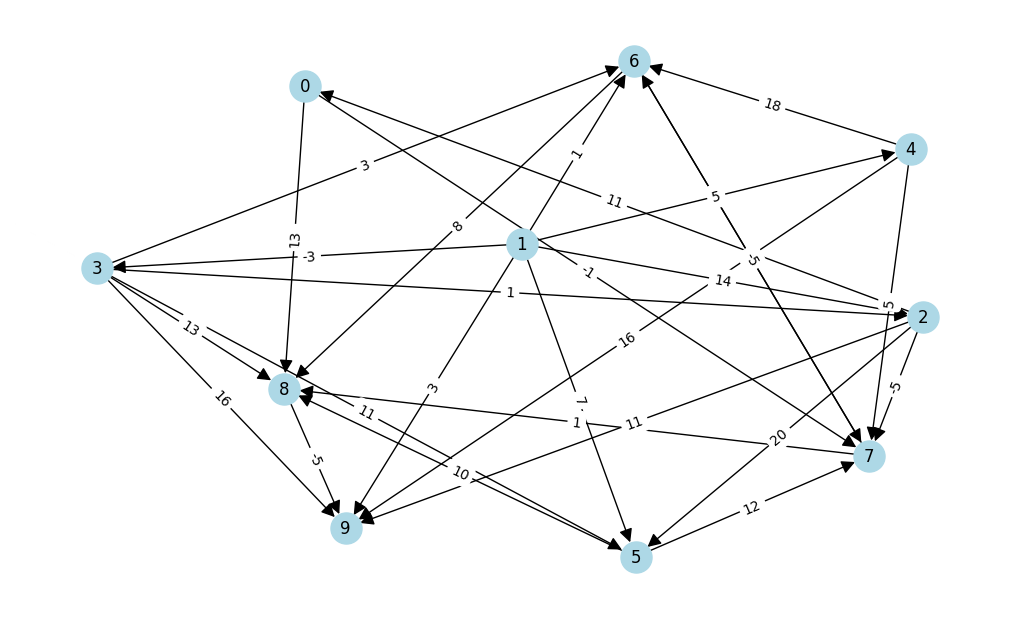

In [25]:
G = gnp_random_connected_graph(10, 0.5, True, True)


~~~~~~ Testing with 10 vertices ~~~~~~


Measuring for 10 vertices: 100%|██████████| 50/50 [00:00<00:00, 1818.31it/s]


Algorithm custom floyd-warshall on 10 vertices: avg time = 0.000149 seconds
Algorithm networkx floyd-warshall on 10 vertices: avg time = 0.000193 seconds

~~~~~~ Testing with 20 vertices ~~~~~~


Measuring for 20 vertices: 100%|██████████| 50/50 [00:00<00:00, 167.01it/s]


Algorithm custom floyd-warshall on 20 vertices: avg time = 0.000832 seconds
Algorithm networkx floyd-warshall on 20 vertices: avg time = 0.001006 seconds

~~~~~~ Testing with 25 vertices ~~~~~~


Measuring for 25 vertices: 100%|██████████| 50/50 [00:00<00:00, 64.20it/s]


Algorithm custom floyd-warshall on 25 vertices: avg time = 0.001495 seconds
Algorithm networkx floyd-warshall on 25 vertices: avg time = 0.001844 seconds

~~~~~~ Testing with 30 vertices ~~~~~~


Measuring for 30 vertices: 100%|██████████| 50/50 [00:01<00:00, 29.64it/s]


Algorithm custom floyd-warshall on 30 vertices: avg time = 0.002459 seconds
Algorithm networkx floyd-warshall on 30 vertices: avg time = 0.003063 seconds

~~~~~~ Testing with 45 vertices ~~~~~~


Measuring for 45 vertices: 100%|██████████| 50/50 [00:09<00:00,  5.15it/s]


Algorithm custom floyd-warshall on 45 vertices: avg time = 0.008212 seconds
Algorithm networkx floyd-warshall on 45 vertices: avg time = 0.009729 seconds

~~~~~~ Testing with 50 vertices ~~~~~~


Measuring for 50 vertices: 100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


Algorithm custom floyd-warshall on 50 vertices: avg time = 0.010550 seconds
Algorithm networkx floyd-warshall on 50 vertices: avg time = 0.012861 seconds


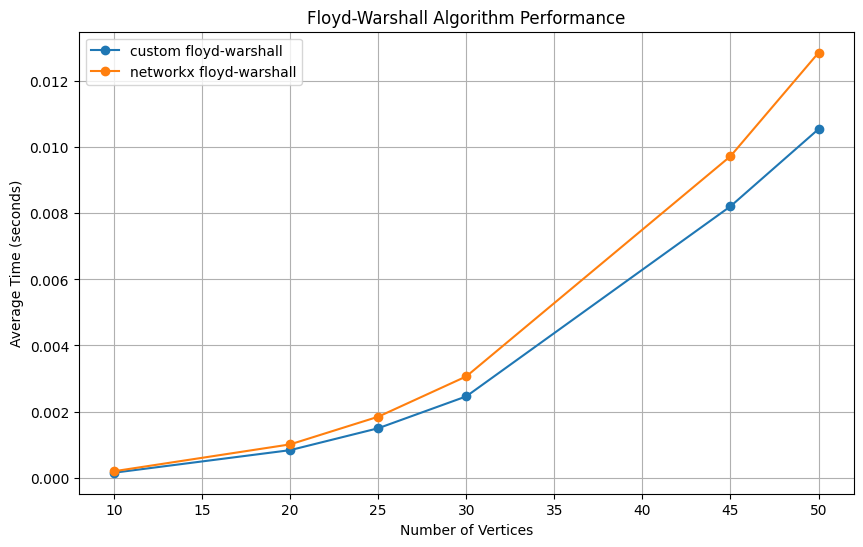

In [ ]:
algorithms = {
    "custom floyd-warshall": lambda G: floyd_warshall(G),
    "networkx floyd-warshall": lambda G: floyd_warshall_predecessor_and_distance(G),
}

vertex_counts = [10, 20, 25, 30, 45, 50]
iterations = 50

results = compare_algorithms(vertex_counts, algorithms, iterations=iterations, completeness=0.5, safe_graph=True, directed=True)

plt.figure(figsize=(10, 6))
for alg_name, data in results.items():
    nodes, times = zip(*data)
    plt.plot(nodes, times, marker='o', label=alg_name)

plt.xlabel("Number of Vertices")
plt.ylabel("Average Time (seconds)")
plt.title("Floyd-Warshall Algorithm Performance")
plt.legend()
plt.grid(True)
plt.show()

### **Conclusion**

NetworkX’s **Floyd-Warshall** implementation is faster because it leverages internal optimizations, such as efficient data structures and performance enhancements through Cython.

---

### **Comparison of custom FLoyd-Warshall's and Bellman-Ford's algorithms.**


~~~~~~ Testing with 10 vertices ~~~~~~


Measuring for 10 vertices: 100%|██████████| 50/50 [00:00<00:00, 1781.25it/s]


Algorithm custom floyd-warshall on 10 vertices: avg time = 0.000148 seconds
Algorithm custom bf on 10 vertices: avg time = 0.000158 seconds

~~~~~~ Testing with 20 vertices ~~~~~~


Measuring for 20 vertices: 100%|██████████| 50/50 [00:00<00:00, 179.23it/s]


Algorithm custom floyd-warshall on 20 vertices: avg time = 0.000869 seconds
Algorithm custom bf on 20 vertices: avg time = 0.000717 seconds

~~~~~~ Testing with 25 vertices ~~~~~~


Measuring for 25 vertices: 100%|██████████| 50/50 [00:00<00:00, 63.65it/s]


Algorithm custom floyd-warshall on 25 vertices: avg time = 0.001492 seconds
Algorithm custom bf on 25 vertices: avg time = 0.001235 seconds

~~~~~~ Testing with 30 vertices ~~~~~~


Measuring for 30 vertices: 100%|██████████| 50/50 [00:01<00:00, 26.75it/s]


Algorithm custom floyd-warshall on 30 vertices: avg time = 0.002494 seconds
Algorithm custom bf on 30 vertices: avg time = 0.001984 seconds

~~~~~~ Testing with 45 vertices ~~~~~~


Measuring for 45 vertices: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Algorithm custom floyd-warshall on 45 vertices: avg time = 0.007754 seconds
Algorithm custom bf on 45 vertices: avg time = 0.007074 seconds

~~~~~~ Testing with 50 vertices ~~~~~~


Measuring for 50 vertices: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]

Algorithm custom floyd-warshall on 50 vertices: avg time = 0.010684 seconds
Algorithm custom bf on 50 vertices: avg time = 0.008355 seconds


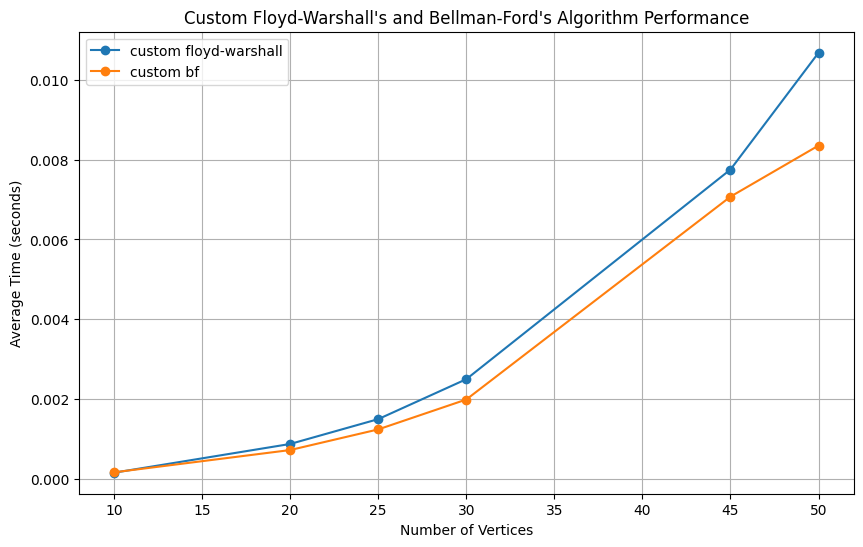

In [27]:
algorithms = {
    "custom floyd-warshall": lambda G: floyd_warshall(G),
    "custom bf": lambda G: bf_algorithm(G, 0),
}

vertex_counts = [10, 20, 25, 30, 45, 50]
iterations = 50

results = compare_algorithms(vertex_counts, algorithms, iterations=iterations, completeness=0.5, safe_graph=True)

# Plotting
plt.figure(figsize=(10, 6))
for alg_name, data in results.items():
    nodes, times = zip(*data)
    plt.plot(nodes, times, marker='o', label=alg_name)

plt.xlabel("Number of Vertices")
plt.ylabel("Average Time (seconds)")
plt.title("Custom Floyd-Warshall's and Bellman-Ford's Algorithm Performance")
plt.legend()
plt.grid(True)
plt.show()

### **Conclusion**

 **Bellman-Ford** and **Floyd-Warshall** are almost the same, both solving the shortest path problem, but **Bellman-Ford** is typically faster for sparse graphs.

---

## **Task 2. Decision Tree Classifier** 

### **Defining node class** 

The purpose of the class is act as a block in a decision tree, where each node makes a split or a leaf node containing a class label.

In [28]:
class Node:
    """
    A node in decision tree, which contains information about the feature
    index used for splitting, the threshhol value and references to child node
    Also have a class label as value if it is a leaf

    :param feature_index: index used in split (default: None)
    :param threshold: value used in split (default: None)
    :param left: left child (default: None)
    :param right: right child (default: None)
    :param value: label if the node is a leaf (default: None)
    """
    def __init__(
        self,
        feature_index: Optional[int] = None,
        threshold: Optional[float] = None,
        left: Optional['Node'] = None,
        right: Optional['Node'] = None,
        *,
        value: Optional[int] = None
    ):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self) -> bool:
        """
        Checks if the node is a leaf.

        Returns:
            bool: True if the node is a leaf else False.
        """
        return self.value is not None


---

### **Decision Tree Classifier**


The main purpose of this is to recursively split the datasets and to classify data points based on features.

In [29]:
class DecisionTreeClassifier:
    """
    Decision Tree Classifier:
    This classifier recursively splits the dataset using the best feature-thershold pair.
    to define the best pair we use Gini impurity metric. The tree growth until the specified depth exceeded.

    :param max_depth: The max depth for tree
    :param n_features: Features consideres for splitting at each node
    :param min_sample_split: Samples required to split the internal node
    :param number_of_classes: The number of unqiue classes in the dataset
    """
    def __init__(self, max_depth: int, n_features=None,
                 min_sample_split=2) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None
        self.root = None
        self.n_features = n_features
        self.min_sample_split = min_sample_split

    def __grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Check the stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_sample_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_indices = np.random.choice(
            n_feats, self.n_features if self.n_features else n_feats, replace=False
        )

        # Find the best split using Gini impurity
        best_feature, best_threshold = self._best_split(X, y, feat_indices)
        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self.__grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self.__grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(
            feature_index=best_feature, threshold=best_threshold, left=left, right=right
        )

    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Uses as the training function for dataset

        Parameters:
         - X (npt.NDArray): Features
         - y (npt.NDArray): Target vector
        """
        self.n_features = (
            X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        )
        self.number_of_classes = np.unique(y).size
        self.root = self.__grow_tree(X, y)

    def predict(self, X_test: npt.NDArray) -> np.ndarray:
        """
        Classify the test data based on the builded tree
        """
        return np.array([self._traverse_tree(x, self.root) for x in X_test])

    def _traverse_tree(self, x: npt.NDArray, node: Node):
        """
        Recursively traverse the tree to predict the class for a given values

        Args:
            x (npt.NDArray): A one-dimmensional Numpy array with feature values
            node (Node): The current internal node in the decision tree

        Returns:
            The predicted class for the sample
        """
        if node.is_leaf():
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _best_split(self, X: npt.NDArray,
                    y: npt.NDArray, feat_indices: npt.NDArray) -> tuple[Optional[int], Optional[float]]:
        """
        Determine the best feature and threshold to split the dataset

        Parameters:
            X (np.ndarray): A 2D NumPy array of shape (n_samples, n_features) containing the dataset features.
            y (np.ndarray): A 1D NumPy array of shape (n_samples,) containing the target class labels.
            feat_indices (np.ndarray): An array or iterable of integers representing the indices of features to consider
                                       for splitting.

        Returns:
            tuple:
                - split_idx (Optional[int]): The index of the feature that provides the best split. If no valid split is found,
                                             returns None.
                - split_threshold (Optional[float]): The threshold value corresponding to the best split. If no valid split is
                                                       found, returns None.
        """
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_indices:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:

                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _information_gain(self, y: npt.NDArray[Any], X_column: npt.NDArray[Any], threshold: float) -> float:
        """
        For every potential split computes the Gini impurity

        Parameters:
            y (NDArray[Any]): A one-dimensional NumPy array containing the target labels for the current node.
            X_column (NDArray[Any]): A one-dimensional NumPy array of feature values corresponding to the candidate feature.
            threshold (float): The value at which to split the data into left and right groups.

        Returns:
            float: The computed information gain (reduction in impurity) resulting from the split.

        """
        parent_impurity = self._gini(y)

        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        impurity_left = self._gini(y[left_idxs])
        impurity_right = self._gini(y[right_idxs])
        weighted_impurity = (n_left / n) * impurity_left + (
            n_right / n
        ) * impurity_right


        return parent_impurity - weighted_impurity

    def _split(self, X_column: npt.NDArray[Any],
               split_threshold: float) -> Tuple[npt.NDArray[np.int_], npt.NDArray[np.int_]]:
        """
        Split the indices of the samples based on a threshold for a given feature.

        Args:
            X_column (NDArray[Any]): A one-dimensional NumPy array containing the values of a specific feature.
            split_threshold (float): The threshold value used to split the data.

        Returns:
            Tuple[NDArray[np.int_], NDArray[np.int_]]:
                A tuple containing two arrays:
                - The first array consists of indices where the feature value is less than or equal to the threshold.
                - The second array consists of indices where the feature value is greater than the threshold.
        """
        # Returns the indeces of the elements in an array that satisfy the condition

        left_idxs = np.argwhere(X_column <= split_threshold).flatten()
        right_idxs = np.argwhere(X_column > split_threshold).flatten()
        return left_idxs, right_idxs

    def _gini(self, y: npt.NDArray) -> float:
        """
        Calculate the Gini impurity

        Args:
            y (NDArray[int]): A one-dimensional NumPy array containing the class labels.

        Returns:
            float: The calculated Gini impurity.
        """
        # Counts the number of occurences of each integer in the array
        hist = np.bincount(y)
        ps = hist / len(y)
        return 1 - np.sum(ps**2)

    def _most_common_label(self, y: npt.NDArray) -> int:
        """
        This function identifies the most common (frequent) class label
        in a given set of target values.
        It is typically used to assign a prediction at a leaf node of the decision
        tree when further splitting is not possible or necessary.
        Args:
            y (_type_): _description_

        Returns:
            _type_: _description_
        """

        counter = Counter(y)
        return counter.most_common(1)[0][0]

### **Step by step explanation**

1. **Fit**
   - 1.1 We define the number of features that we need to take into account while splitting.

   - 1.2 Calculate the unique classes in the target variable `y`
   
   - 1.3 Calling the method to construct the decision tree

2. **Predict**
   - 2.1 The `predict` method takes an input as `X_test`

   - 2.2 We iterate through each sample data in the test dataset. 
   
   - 2.3 We call the `travese_tree` - the purpose is to check which branch to follow based on the values

3. **Traverse the tree**
   - 3.1 Based on conditions determine the class for the `x` - feature by following the tree

4. **Finding best split**
   - 4.1 The purpose of finding the hights `information gain`

   - 4.2 We are trying to find the best splitting indexes by iterating through the thresholds
      - 4.2. 1 For each feature index (`feat_idx`), it extracts the corresponding column from X (i.e., X_column = `X[:, feat_idx]`), which represents the values of that feature across all samples.
It then finds all unique values in this column using np.unique(X_column). Each unique value is a potential threshold for splitting the data on that feature. 

   - 4.3 We rate the information gain for each threshold. The idea is to find the highest value

5. **Information gain***
   - 5.1 Calculate the Gini impurity for the parent using target labels

   - 5.2 Split the data into two groups   
   
   - 5.3 Calculate the Gini impurity for left and right split

   - 5.4 Calculate the weighted impurity for the split, where the weight is the proportion of the samples in the group
   
   - 5.5 The information gain is the difference between the parent and the impurity of the split

6. **Split**
   - 6.1 This function is used to partition the data based on a threshold value for a specific feature. It splits the indices of the samples into two groups:
 Left group: All samples where the feature value is less than or equal to the split threshold.
 Right group: All samples where the feature value is greater than the split threshold.

7. **Calculate the Gini**

8. **Mot common label**
   - 8.1 This function identifies the most common (frequent) class label in a given set of target values. It is typically used to assign a prediction at a leaf node of the decision tree when further splitting is not possible or necessary.





### **Working with dataset**

First 5 rows of the dataset:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter 

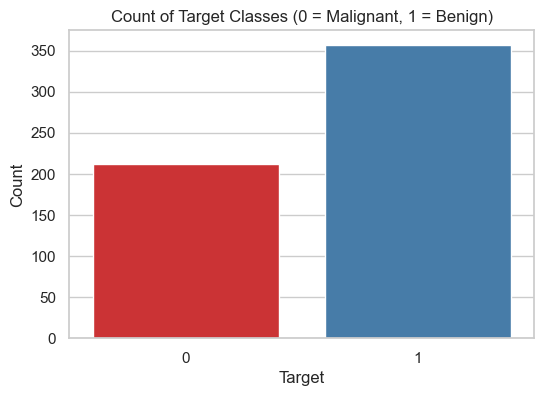

In [30]:
sns.set(style="whitegrid", context="notebook")


data = load_breast_cancer()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

print("First 5 rows of the dataset:")
print(df.head())

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, hue='target', palette='Set1', legend=False)
plt.title("Count of Target Classes (0 = Malignant, 1 = Benign)")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()


We see the basic distibution among Malignant and Bening

In [31]:
target_counts = df['target'].value_counts()
target_counts

target
1    357
0    212
Name: count, dtype: int64

357 - reffers to Bening

212 - reffers to Malingnant

#### **Features graph**

We may see the first two featues in data set 

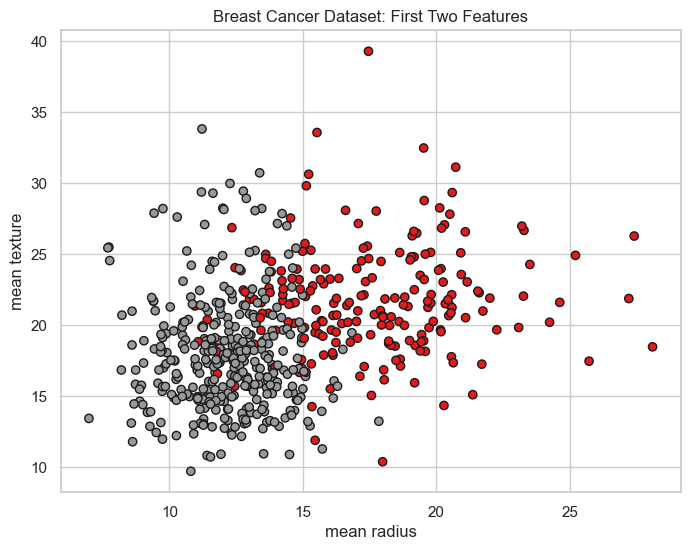

In [32]:
data = load_breast_cancer()
X = data.data[:, :2]
y = data.target
plt.figure(figsize=(8, 6))
plt.clf()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
plt.title("Breast Cancer Dataset: First Two Features")
plt.show()

---

### **Training the tree and classifying the data**

Model Accuracy: 0.95


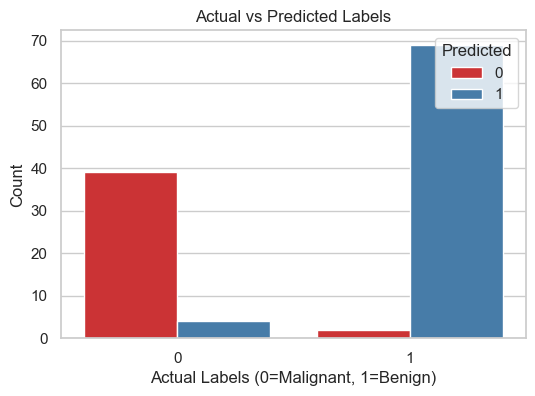

In [33]:
data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = DecisionTreeClassifier(max_depth=3, n_features=X.shape[1])
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.countplot(x=y_test, hue=y_pred, palette="Set1")
plt.title("Actual vs Predicted Labels")
plt.xlabel("Actual Labels (0=Malignant, 1=Benign)")
plt.ylabel("Count")
plt.legend(title="Predicted", loc="upper right")
plt.show()



---

### **Ploting confusion matrix**

To understand the data clearly, we may want to see the confusion matrix for diseases. It is usually a matrix with True Positive, True Negative, False Positive, and False Negative values.

Model Accuracy (on full dataset): 0.98

Confusion Matrix:
 [[204   8]
 [  4 353]]
Percentage of malignant (ill) cases predicted as malignant: 96.23%
Percentage of malignant (ill) cases predicted as benign: 3.77%
Percentage of benign (not ill) cases predicted as malignant: 1.12%
Percentage of benign (not ill) cases predicted as benign: 98.88%

Classification Report:
               precision    recall  f1-score   support

   Malignant       0.98      0.96      0.97       212
      Benign       0.98      0.99      0.98       357

    accuracy                           0.98       569
   macro avg       0.98      0.98      0.98       569
weighted avg       0.98      0.98      0.98       569



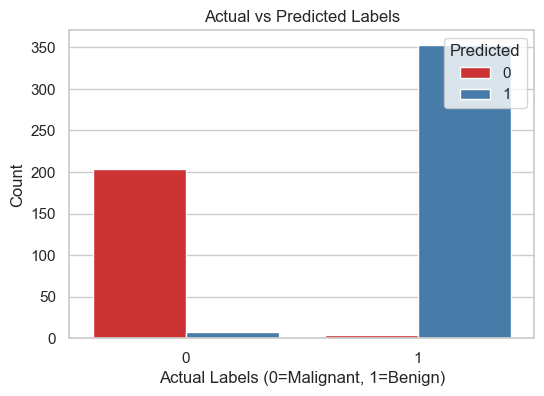

In [34]:
data = load_breast_cancer()
X, y = data.data, data.target

tree = DecisionTreeClassifier(max_depth=3, n_features=X.shape[1])
tree.fit(X, y)

y_pred = tree.predict(X)

accuracy = accuracy_score(y, y_pred)
print(f"Model Accuracy (on full dataset): {accuracy:.2f}")

cm = confusion_matrix(y, y_pred, labels=[0, 1])
print("\nConfusion Matrix:\n", cm)

total_ill = cm[0, 0] + cm[0, 1]
total_not_ill = cm[1, 0] + cm[1, 1]

perc_ill_pred_ill = (cm[0, 0] / total_ill) * 100 if total_ill > 0 else 0
perc_ill_pred_not_ill = (cm[0, 1] / total_ill) * 100 if total_ill > 0 else 0
perc_not_ill_pred_ill = (cm[1, 0] / total_not_ill) * 100 if total_not_ill > 0 else 0
perc_not_ill_pred_not_ill = (cm[1, 1] / total_not_ill) * 100 if total_not_ill > 0 else 0

print(f"Percentage of malignant (ill) cases predicted as malignant: {perc_ill_pred_ill:.2f}%")
print(f"Percentage of malignant (ill) cases predicted as benign: {perc_ill_pred_not_ill:.2f}%")
print(f"Percentage of benign (not ill) cases predicted as malignant: {perc_not_ill_pred_ill:.2f}%")
print(f"Percentage of benign (not ill) cases predicted as benign: {perc_not_ill_pred_not_ill:.2f}%")

print("\nClassification Report:\n", classification_report(y, y_pred, target_names=["Malignant", "Benign"]))

plt.figure(figsize=(6, 4))
sns.countplot(x=y, hue=y_pred, palette="Set1")
plt.title("Actual vs Predicted Labels")
plt.xlabel("Actual Labels (0=Malignant, 1=Benign)")
plt.ylabel("Count")
plt.legend(title="Predicted", loc="upper right")
plt.show()


As we see the chance of trained model to make a mistake is precisely small

---

### **Building the graph for the whole tree**

![alt text](custom_cancer_tree.png)